In [1]:
!pip install -r requirements.txt --quiet --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.2 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.0.0 which is incompatible.


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
import yfinance as yf
import time
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline
plt.rcParams['figure.figsize'] =  (22,5)
plt.rcParams['font.size'] = 14

In [3]:
symbol = 'GOOGL'
df = yf.Ticker(symbol).history(period='max').reset_index()
df['Date'] = df['Date'].dt.date
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2004-08-19,2.499634,2.601119,2.398648,2.508132,893181924,0.0,0.0
1,2004-08-20,2.524880,2.726600,2.512132,2.707353,456686856,0.0,0.0
2,2004-08-23,2.768345,2.836584,2.725851,2.734599,365122512,0.0,0.0
3,2004-08-24,2.780593,2.789591,2.588871,2.621365,304946748,0.0,0.0
4,2004-08-25,2.623616,2.699605,2.596620,2.649612,183772044,0.0,0.0


In [5]:
df.dtypes

Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Dividends              float64
Stock Splits           float64
dtype: object

In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,5005,2014-07-27 19:12:51.788211968,2004-08-19 00:00:00,2009-08-07 00:00:00,2014-07-29 00:00:00,2019-07-18 00:00:00,2024-07-09 00:00:00,NaN
Open,5005.0,44.84782,2.479387,13.048088,27.514421,60.178935,190.229996,42.33961
High,5005.0,45.318422,2.543127,13.184569,27.727678,60.656388,191.360001,42.809636
Low,5005.0,44.388002,2.398648,12.908108,27.250226,59.81785,189.869995,41.913753
Close,5005.0,44.867394,2.499884,13.056837,27.462481,60.284813,190.600006,42.382652
Volume,5005.0,117770743.945455,2457791.0,31113000.0,60314000.0,142409448.0,1643023332.0,148045667.517262
Dividends,5005.0,0.00004,0.0,0.0,0.0,0.0,0.2,0.002827
Stock Splits,5005.0,0.004395,0.0,0.0,0.0,0.0,20.0,0.284103


In [7]:
print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns')

The data has 5005 rows and 8 columns


Lets look at the movement of Various figures (Open, High, Low, Close) over the months

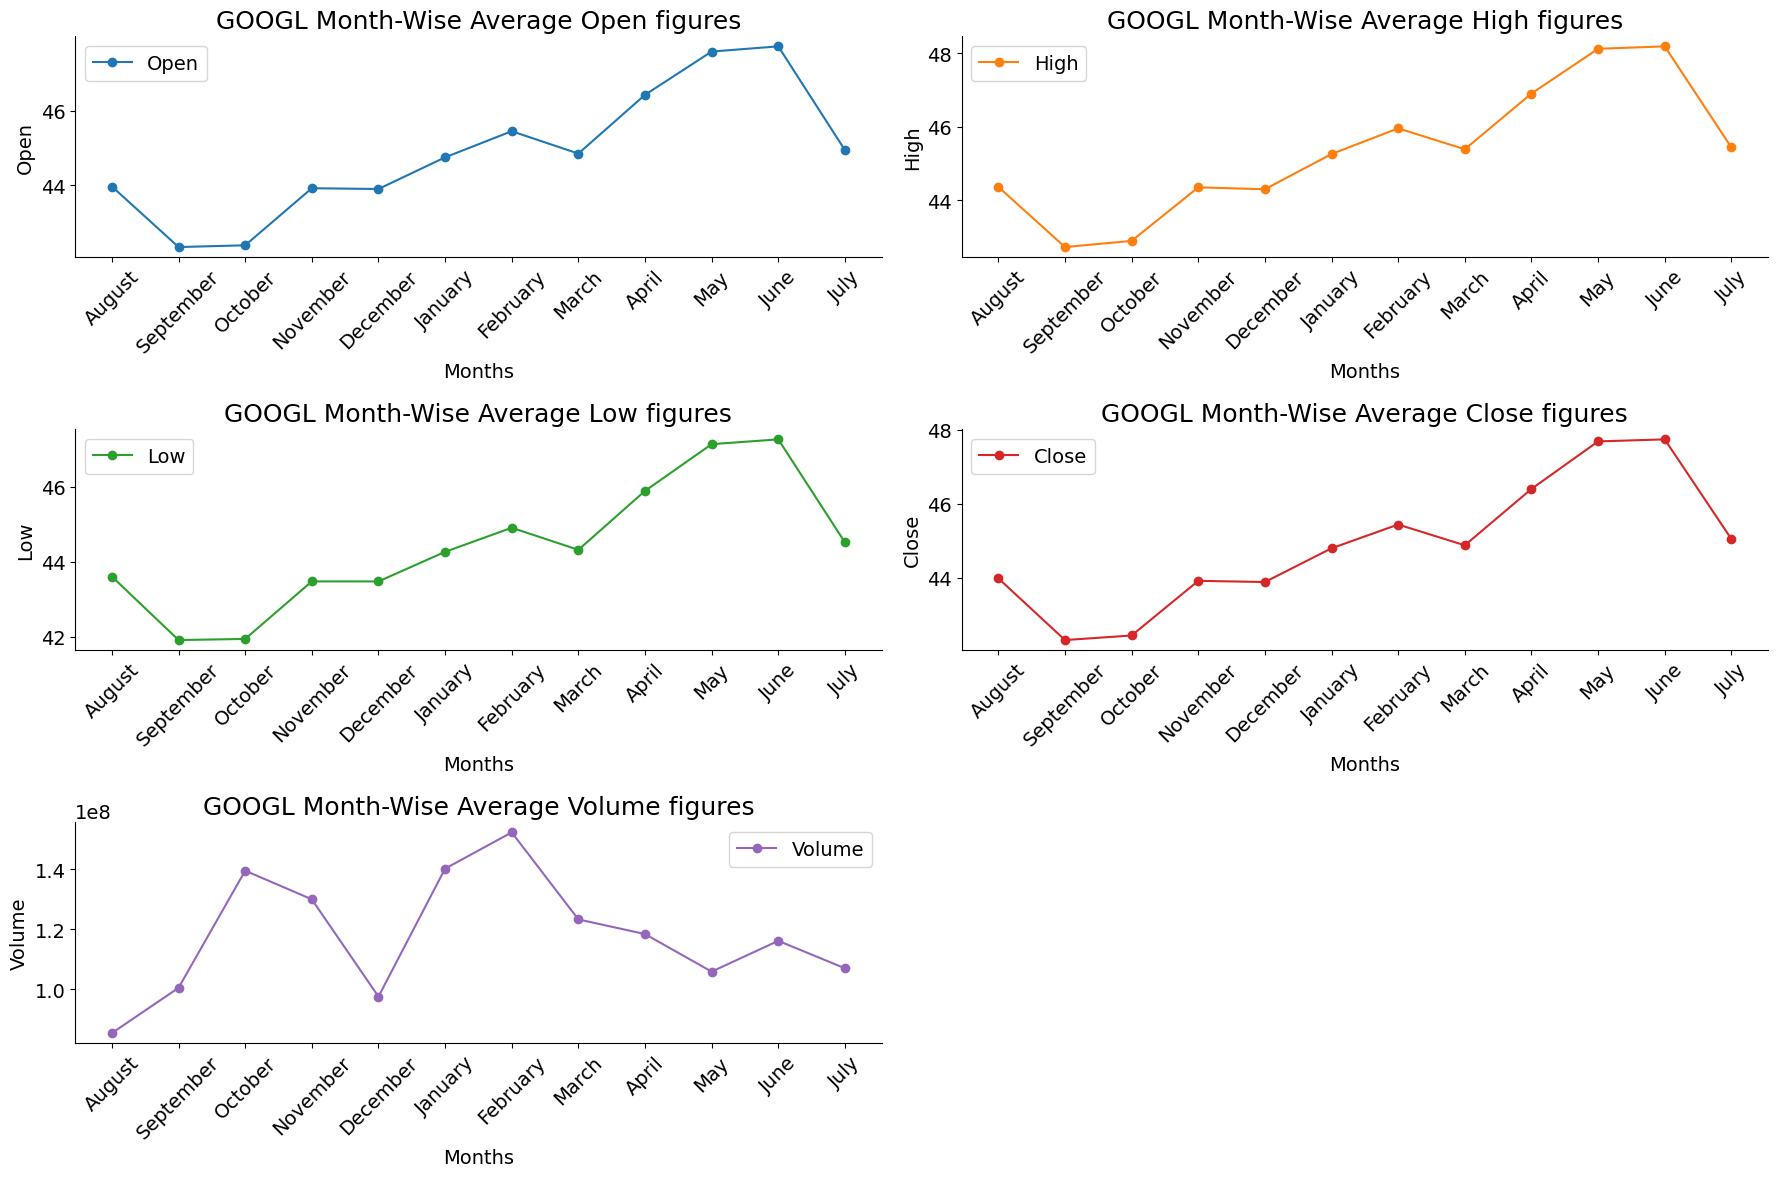

In [8]:
colors = plt.rcParams["axes.prop_cycle"]()
a = 3  # number of rows
b = 2  # number of columns
c = 1  # initialize plot df

#Set the figure size of the plot
fig = plt.figure(figsize=(18,12))

n = len(df.groupby(df['Date'].dt.month_name(), sort=False).mean().columns[1:-2])

#Loop through the each column in the dataframe to generate a subplot
for i in range(1,n+1):
    color = next(colors)["color"]
    #Generate a subplot with the given dimensions
    plt.subplot(a, b, c)
    #Plot the data in a line graph, with different colors for each line
    plt.plot(df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i], color= color, marker='o')
    #Remove the top and right borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #Rotate the x-tick labels by 45 degrees
    plt.xticks(rotation=45)
    #Set the title, x-axis label, y-axis label, and legend
    plt.title(f"{symbol} Month-Wise Average {df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i].name} figures", fontsize=18)
    plt.xlabel('Months')
    plt.ylabel(df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i].name)
    plt.legend([df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i].name])
    #Increment the subplot df
    c = c + 1

#Adjust the layout of the plot
plt.tight_layout()
#Show the plot
plt.show()

**INSIGHTS**

- Open, High, Low and close figures reach the maximum values around June month.
- Volume Avge Figures reach the max figures between January and February.

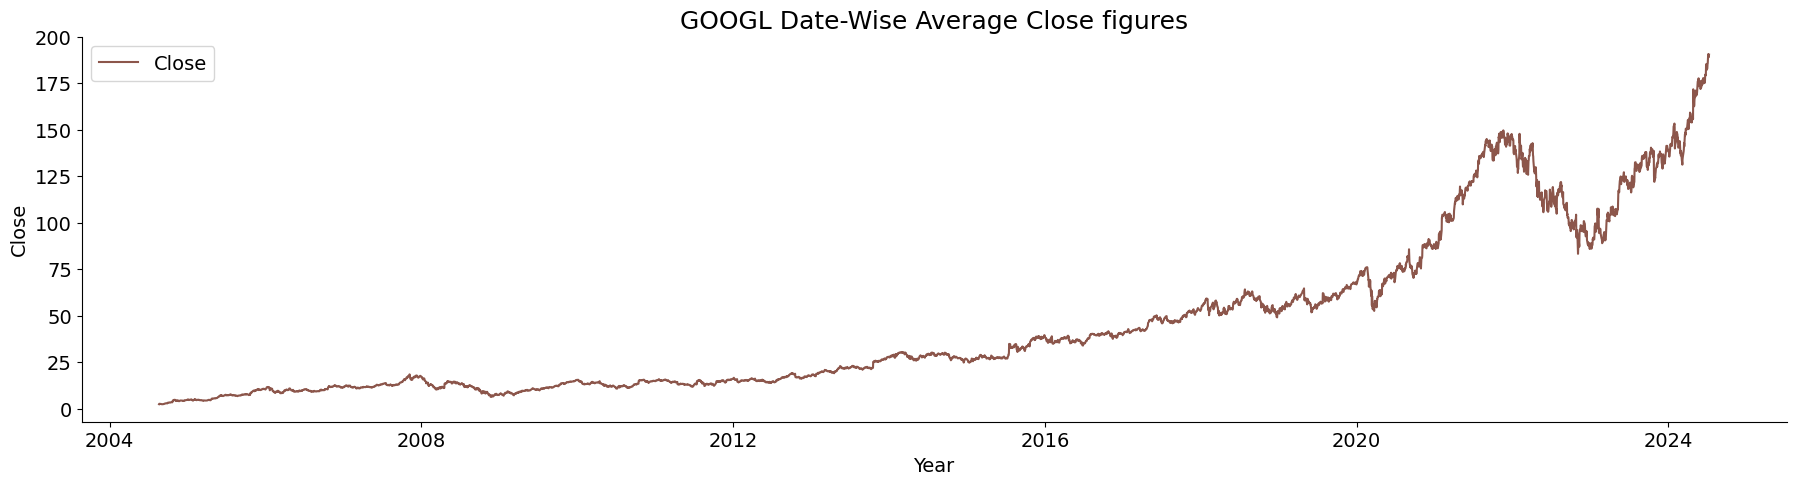

In [9]:
plt.plot(df.groupby(df['Date'], sort=False).mean().Close, color= next(colors)["color"])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Rotate the x-tick labels by 45 degrees
plt.xticks(rotation=0)
#Set the title, x-axis label, y-axis label, and legend
plt.title(f"{symbol} Date-Wise Average Close figures", fontsize=18)
plt.xlabel('Year')
plt.ylabel('Close')
plt.legend(['Close'])
plt.show()

**INSIGHTS**

- There is an upward trend in the price of Google which is definitely a good sign for the company and it's shareholders.

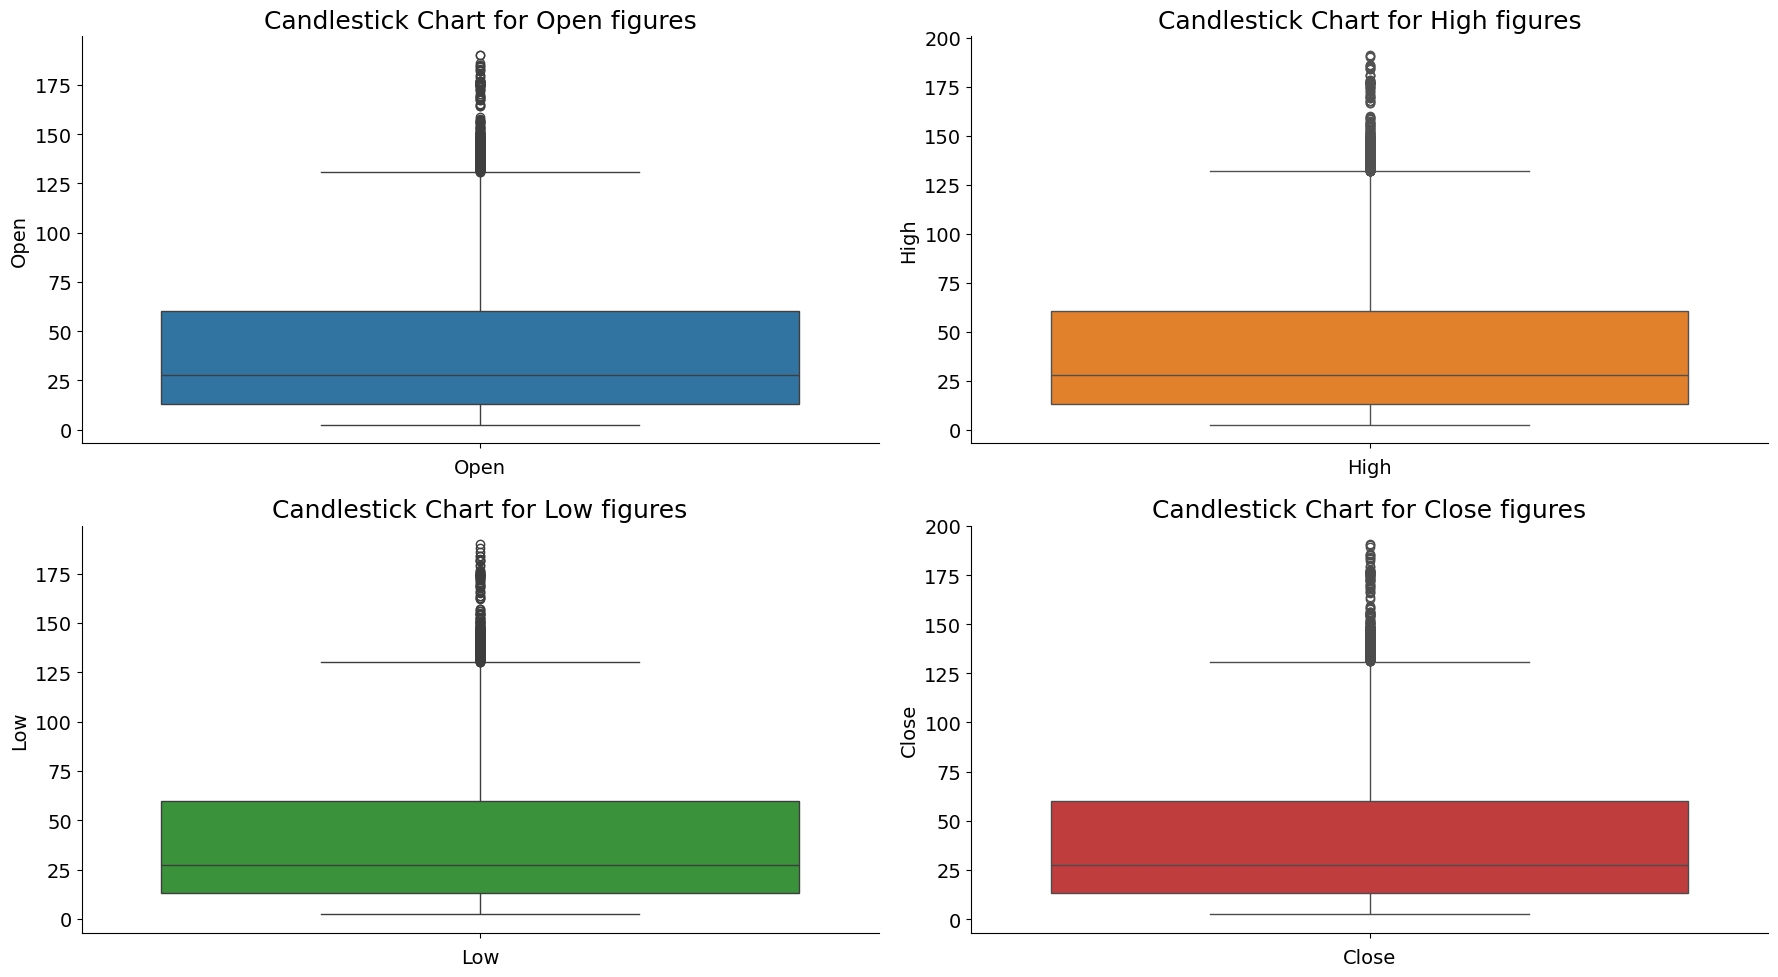

In [10]:
# This code plots boxplots of various columns in a dataframe, data_hist.

colors = plt.rcParams["axes.prop_cycle"]()

# The number of rows, columns, and the subplot counter are initialized. 
a = 2  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

# A figure is initialized  
fig = plt.figure(figsize=(18,10))

length = range(1,len(df.columns[:-3]))

#loop is used to iterate over the columns of dataframe. 
for i in length:
    color = next(colors)["color"]
    plt.subplot(a, b, c)
    #For each column, a boxplot is plotted and labels and titles are set accordingly. 
    sns.boxplot(df[df.columns[i]], color= color )
    # The spines of each plot are made invisible and the figure is adjusted and shown.
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #X Axis label is added
    plt.xlabel(df.columns[i])
    #title to the plot is added
    plt.title(f'Candlestick Chart for {df.columns[i]} figures', fontsize=18)
    c = c + 1

#Layout is tightended up
plt.tight_layout()

#plot is displayed
plt.show()

## ARMA 


### Auto-Regressive (AR)

- A Statistical model that tries to predict the values based on lagged values and the lag could be chosen as per the wish.

- The AR part of the model involves regressing the variable on its own lagged (past) values. The order of the AR part is denoted by `p`

- **For Example**: Sales of 9th month could be predicted based on 7th and 8th Month.


The AR part of the model is calculated by the below formula:-

**Formula:**
$$ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \phi_3 X_{t-3} + \cdots + \phi_p X_{t-p} + \epsilon_t $$

Where:
- $ X_t $ is the value of the series at time $ t $.
- $ c $ is the constant term (intercept).
- $ \phi_i $ (for $ i = 1, 2, \ldots, p $) are the coefficients (calculated using OLS method) of the lagged values.
- $ X_{t-i} $ are the lagged values of the series.
- $ \epsilon_t $ is the error term (white noise) at time $ t $.


For example, for an AR(2) model (where $ p = 2 $), the equation would be:

$$ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \epsilon_t $$

This explicitly shows that $ X_t $ depends on the two most recent past values of the series, $ X_{t-1} $ and $ X_{t-2} $. Similarly, for an AR(n) model (where p = infinity ), the equation would be:

$$ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + ..... + \phi_n X_{t-n}\epsilon_t $$

In [11]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2004-08-19,2.499634,2.601119,2.398648,2.508132,893181924,0.0,0.0
1,2004-08-20,2.524880,2.726600,2.512132,2.707353,456686856,0.0,0.0
2,2004-08-23,2.768345,2.836584,2.725851,2.734599,365122512,0.0,0.0
3,2004-08-24,2.780593,2.789591,2.588871,2.621365,304946748,0.0,0.0
4,2004-08-25,2.623616,2.699605,2.596620,2.649612,183772044,0.0,0.0


In [12]:
#shifting the data by 1 and 2 rows, shifting would mean pushing the data n rows forward
df['Close_Lag_1'], df['Close_Lag_2'] = df['Close'].shift(1), df['Close'].shift(2)

df.dropna(inplace=True)

df_lagged = df[['Close','Close_Lag_1', 'Close_Lag_2']]

X = df_lagged[['Close_Lag_1', 'Close_Lag_2']]
X['Intercept'] = 1
y = df_lagged['Close']

# Use numpy's least squares to estimate parameters
params = np.linalg.lstsq(X, y, rcond=None)[0]
phi_1, phi_2, c = params[0], params[1], params[2]

print(f"Estimated parameters: c = {c:.4f}, phi_1 = {phi_1:.4f}, phi_2 = {phi_2:.4f}")

# Step 4: Predict future values
def predict_ar2(X_t_minus_1, X_t_minus_2, c, phi_1, phi_2):
    return c + phi_1 * X_t_minus_1 + phi_2 * X_t_minus_2

# Predict the next value in the series
X_t_minus_1 = df['Close'].iloc[-3]
X_t_minus_2 = df['Close'].iloc[-2]
X_t_pred = predict_ar2(X_t_minus_1, X_t_minus_2, c, phi_1, phi_2)

print("Predicted next value: X_t_pred" , round(X_t_pred,4))

Estimated parameters: c = 0.0036, phi_1 = 0.9453, phi_2 = 0.0555
Predicted next value: X_t_pred 190.6693


In [13]:
#Coefficient for lags (first 2, third is constant term) calculated using ordinary least squares implemented in Numpy
params

array([0.94530618, 0.05549549, 0.00362725])

So the values here 0.94590329, 0.0548866 are the coefficient of lags (2 here) which then gets multiplied by the lagged value of the series and gets summed up (add an random error too) to get the value at the current time stamp.

### Does Changing the Lag Order in the AR Model affect the results?

Yes, changing the order of the lags in the autoregressive model equation will impact the final result. This is because the coefficients $ \phi_i $ in an AR model are specifically tied to particular lagged values of the time series, representing their respective influences on the current value $ X_t $.

In an AR(p) model, each coefficient $ \phi_i $ is associated with a specific lag. The model captures the relationship between $ X_t $ and its past values:

$$ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \cdots + \phi_p X_{t-p} + \epsilon_t $$

If you change the order of the lags, such as $ X_t = c + \phi_1 X_{t-2} + \phi_2 X_{t-3} + \phi_3 X_{t-1} + \cdots + \phi_p X_{t-p} + \epsilon_t $ you are altering which lagged value is associated with which coefficient. This means:

1. **Different Relationships**: The model will now capture different relationships between $ X_t $ and its past values. For example, $ \phi_1 $ will now be the coefficient for $ X_{t-2} $ instead of $ X_{t-1} $.
2. **Estimation Changes**: When you estimate the parameters using a method like ordinary least squares, the estimated coefficients will change because the input data (lagged values) for each coefficient has changed.
3. **Prediction Impact**: The predictive capability of the model will be different because the model is now using different past values to make predictions about the future.

Talking about the lags, there are 2 functions that we should discuss at this point in time which are ACF and PACF.

## Autocorrelation Function (ACF)

### What is ACF?

The Autocorrelation Function (ACF) helps us understand how current values of a time series are related to its past values. Think of it as a measure of how much past values influence the current value.

### Why is ACF Important?

- It helps us identify patterns in the data.
- It’s used to determine the number of Moving Average (MA) `q` terms in an ARIMA model.

### Example

Imagine you have a series of daily temperatures. The ACF will tell you if today’s temperature is related to yesterday’s temperature, the temperature two days ago, and so on.

### How to Read an ACF Plot

- The x-axis represents the lag (how far back you look).
- The y-axis represents the correlation (how strong the relationship is).
- A significant spike at lag k suggests that the value k days ago has a strong relationship with today’s value.

In [15]:
from statsmodels.tsa.stattools import acf
acf_values = acf(df['Close'], nlags=len(df['Close'])-1)

# Print ACF values
print("ACF Values:", acf_values)

ACF Values: [ 1.00000000e+00  9.98364952e-01  9.96788916e-01 ... -2.04545717e-03
 -1.36053285e-03 -6.82499271e-04]


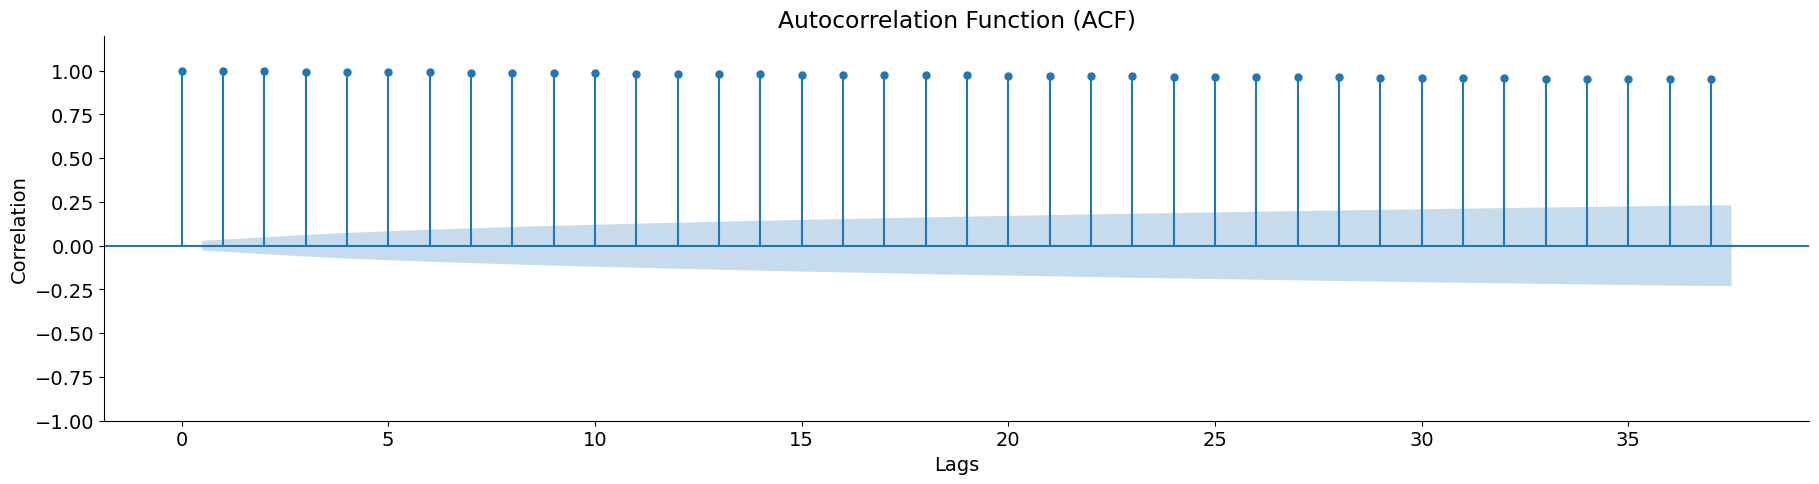

In [29]:
plot_acf(df['Close']) #acf tells q (MA)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Rotate the x-tick labels by 45 degrees
plt.xticks(rotation=0)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Autocorrelation Function (ACF)')
plt.ylim(top=1.2)
plt.show()

We see in the ACF plot above that all the lagged value seem to be strongly correlated with other lags. If the ACF values remain close to 1 for all lags, it suggests that there is a strong persistence in the series. This pattern is unusual for a typical Moving Average (MA) process, where we usually expect the ACF to drop off after a certain number of lags.

### Possible Interpretations:

1. **Non-Stationary Series:** ACF values close to 1 at all lags usually indicate a non-stationary series. Non-stationary series have trends or other structures that cause the high correlations at different lags. In such cases, differencing the series might be necessary to achieve stationarity before determining the MA order.

2. **ARIMA Model:** If the series is non-stationary, you might need to fit an ARIMA model instead of just an MA model. The `I` (Integrated) part of ARIMA accounts for differencing to make the series stationary.

### Steps to Address the Issue:

1. **Check for Stationarity:**
   - Perform a stationarity test such as the Augmented Dickey-Fuller (ADF) test.
   - Plot the time series to visually inspect for trends.

2. **Differencing:**
   - If the series is non-stationary, apply differencing (e.g., first difference) and then re-calculate the ACF.

3. **Re-evaluate the ACF:**
   - After differencing, plot the ACF again to determine if the series is now stationary and the ACF shows a meaningful cut-off for determining $q$.


### Determining $q$:

After differencing, the ACF of the differenced series should ideally show a clear pattern where the correlations drop off after a certain lag. The lag at which the ACF first becomes zero (or close to zero) and stays there can help determine the order $q$ for the MA part of the ARIMA model.

If the ACF values after differencing show a sharp cut-off, that cut-off point is your $q$. If the ACF values still do not show a clear cut-off, you may need to investigate further or consider other aspects of the series, such as seasonality or more complex model structures.

So now lets get the differenced series and what is the lag that should be used for `q` values for the MA Model.

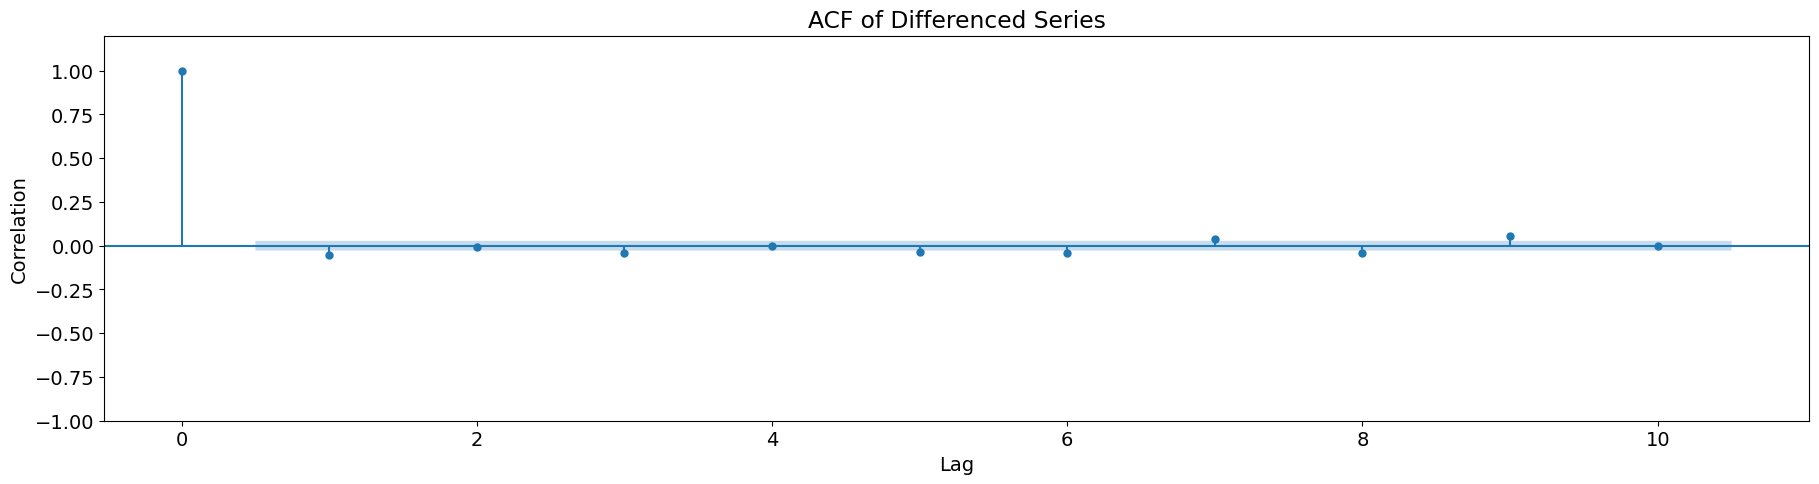

In [28]:
# If non-stationary, apply differencing
differenced_series = np.diff(df['Close'], n=1)

# Plot ACF of differenced series
plot_acf(differenced_series, lags=10)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('ACF of Differenced Series')
plt.ylim(top=1.2)
plt.show()

So now we can see that after differencing the series once, we can easily decide on the number of lags (q value) to use for the Moving Average (MA) model.

When we difference our series, the ACF (Autocorrelation Function) plot helps us see if the series is now stationary. If the ACF plot shows a spike at lag 0 (with a correlation of 1) and all other lags are insignificant, it means that differencing has successfully removed the non-stationarity.

### Understanding the ACF Plot After Differencing:

1. **Lag 0 Correlation:** A spike at lag 0 with a correlation of 1 is normal. It shows that the differenced series is perfectly correlated with itself at lag 0.
2. **Insignificant Correlations at Other Lags:** If other lags have insignificant correlations (i.e., they fall within the confidence interval), it means there's no significant autocorrelation at those lags. This suggests the differenced series is stationary.

### Deciding on $q$ for the MA Model:

If the ACF plot of the differenced series shows no significant spikes beyond lag 0, it suggests that we might not need an MA component, or the MA order (q) could be very small, potentially zero.

In other words, if there are no significant autocorrelations in the differenced series, a Moving Average (MA) model with q = 0 might be enough. However, it's usually a good idea to check other diagnostics and use criteria like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) to confirm the best model order.

### Next Steps:

1. **Fit an ARIMA Model:** Since there are no significant autocorrelations, you can start with a low q value, like q = 0, and see how well the model fits.
2. **Use Model Selection Criteria:** Use AIC or BIC to compare different models and choose the best one.
3. **Model Diagnostics:** Check the residuals (errors) of the fitted model to ensure they look like random noise.

### Adjusting $p$, $d$, $q$:

- **$p$:** Number of autoregressive terms (how many past values to use).
- **$d$:** Number of times you differenced the series to make it stationary.
- **$q$:** Number of lagged forecast errors in the prediction equation.

Since your ACF plot of the differenced series shows no significant spikes beyond lag 0, you might start with q = 0. You can then experiment with different values of p and d to find the best model.

## Partial Autocorrelation Function (PACF)

### What is PACF?

The Partial Autocorrelation Function (PACF) measures the correlation between the time series and its lagged values, but it removes the effects of the intermediate lags. It’s like filtering out the middle steps to see the direct relationship.

### Why is PACF Important?

- It helps us determine the number of Autoregressive (AR) `p` terms in an ARIMA model.

**Example** - Using the same daily temperature example, the PACF will show the direct relationship between today’s temperature and the temperature two days ago, without being influenced by yesterday’s temperature.

### How to Read a PACF Plot

- The x-axis represents the lag.
- The y-axis represents the partial correlation.
- A significant spike at lag k suggests that the value k days ago has a direct relationship with today’s value, independent of the values in between.

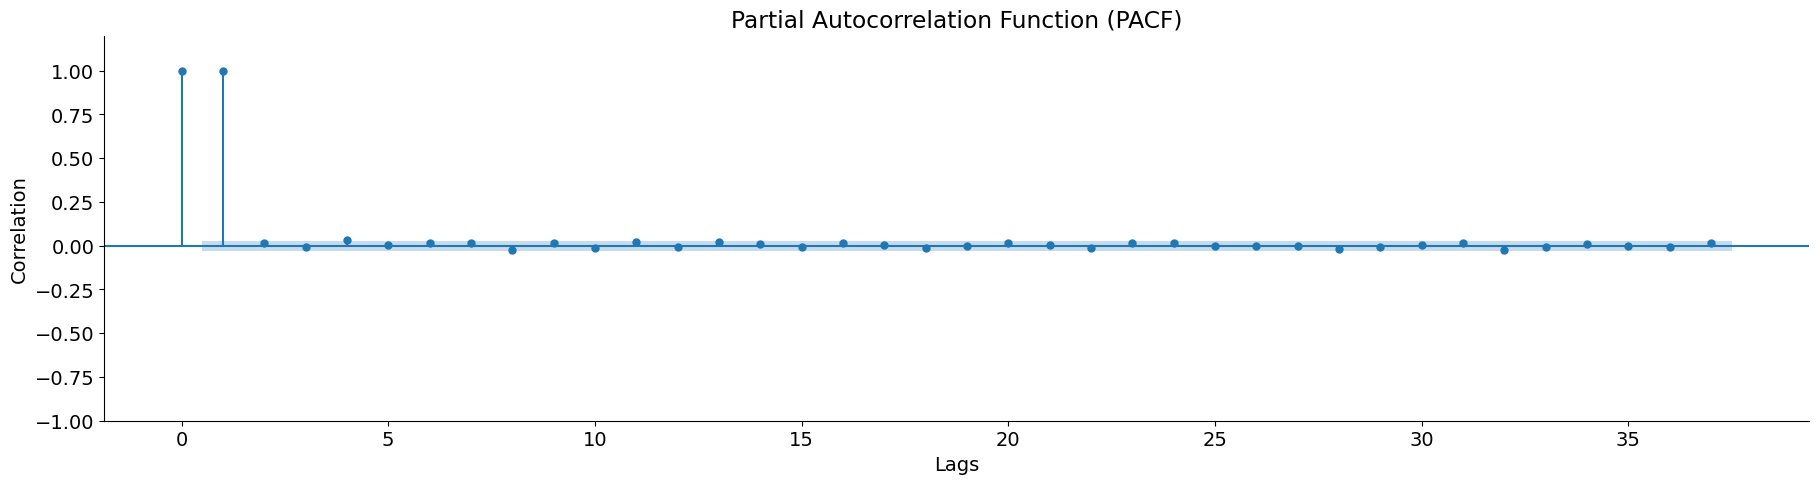

In [30]:
plot_pacf(df['Close']) #pacf tells p (AR)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Rotate the x-tick labels by 45 degrees
plt.xticks(rotation=0)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.ylim(top=1.2)
plt.show()

Now if we were to get the lags here is what we would do:-

1. Take a look at the correlation values. Starting from the left (the value at 0th lag is the orginal series at time t), stop where the correlation value is less than 0.05 (5% significance)
2. In this case the series has a high significance value of the lag at first lag and hence we will take lag = 1
3. We didn't take 2nd lag because its statistically insignificant (less than 0.05 correlation).


*PS : - both the partial autocorrelation function (PACF) and the autocorrelation function (ACF) calculate correlations using the **Pearson correlation coefficient**. This coefficient measures the linear relationship between two variables in a dataset. When applied to time series analysis, it provides valuable insights into the relationship between a variable and its lagged values, aiding in identifying patterns and dependencies within the data.*



## How to Use ACF and PACF for ARMA and ARIMA Modeling

<center> ARMA : <text style="background-color: yellow;"> AR (p) - MA (q) </text> </center>
<center> ARIMA : <text style="background-color: yellow;"> AR (p) - I (d) - MA (q) </text> </center>

1. **Identify AR Order (p)**:
   - Look at the PACF plot.
   - Find where the PACF cuts off (suddenly drops to near zero) – this lag is the AR order (p).

2. **Identify MA Order (q)**:
   - Look at the ACF plot.
   - Find where the ACF cuts off – this lag is the MA order (q).

3. **Identify Differencing Order (d)**:
   - Check if your time series is stationary (its statistical properties do not change over time).
   - If not, determine how many times you need to difference the data to make it stationary.

### Conclusion

- **ACF** helps you see how past values influence the current value.
- **PACF** helps you see the direct relationship between past values and the current value, filtering out the middle steps.
- Together, ACF and PACF help you decide the parameters (p and q) for your ARIMA model.

## Fitting an ARMA Model

So now we have got our `p` and `q` values for the ARMA model let's go ahead and make some predictions to see how close we got with the values we picked out.

However there is something to note here that the statsmodel library has deprecated. As of today, the `statsmodels.tsa.arima_model.ARMA` and `statsmodels.tsa.arima_model.ARIMA` have been removed in favor of `statsmodels.tsa.arima.model.ARIMA` (without _) and `statsmodels.tsa.SARIMAX`.

This is because `statsmodels.tsa.arima.model.ARIMA` makes use of the statespace framework and they're both well tested and maintained. It also offers alternative specialized parameter estimators.

If you try to use ARMA from `statsmodels.tsa.arima_model` you'll get `NotImplementedError` message error so we will just 
import ARIMA from `statsmodels.tsa.arima.model` and use 0 for `d` parameter

In [33]:
exogenous_features = ['Open', 'High', 'Low']
model = ARIMA(df['Close'], order=(1,0,0))
fitted_model = model.fit()

In [35]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 5003
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7734.869
Date:                Tue, 09 Jul 2024   AIC                          15475.739
Time:                        20:30:01   BIC                          15495.292
Sample:                             0   HQIC                         15482.592
                               - 5003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.2155    397.976      0.116      0.908    -733.803     826.234
ar.L1          0.9999      0.000   2306.770      0.000       0.999       1.001
sigma2         1.2872      0.007    179.748      0.000       1.273       1.301
===================================================================================
Ljung-Box (L1) (Q):                  14.39   Jarque-Bera (JB):            119320.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              67.68   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
predictions = fitted_model.predict().to_frame()
predictions['Actual'] = df['Close']
predictions['Date'] = df['Date']
predictions = predictions[['Date', 'Actual', 'predicted_mean']] 
predictions

,Date,Actual,predicted_mean
2,2004-08-23,2.734599,46.215515
3,2004-08-24,2.621365,2.738039
4,2004-08-25,2.649612,2.624814
5,2004-08-26,2.697354,2.653058
6,2004-08-27,2.653361,2.700797
...,...,...,...
5000,2024-07-02,185.240005,182.979187
5001,2024-07-03,185.820007,185.229009
5002,2024-07-05,190.600006,185.808965
5003,2024-07-08,189.029999,190.588585


Now that we have our actual values and the predictions, lets plot them out to see how far off we were. We will make a scatter plot for this.

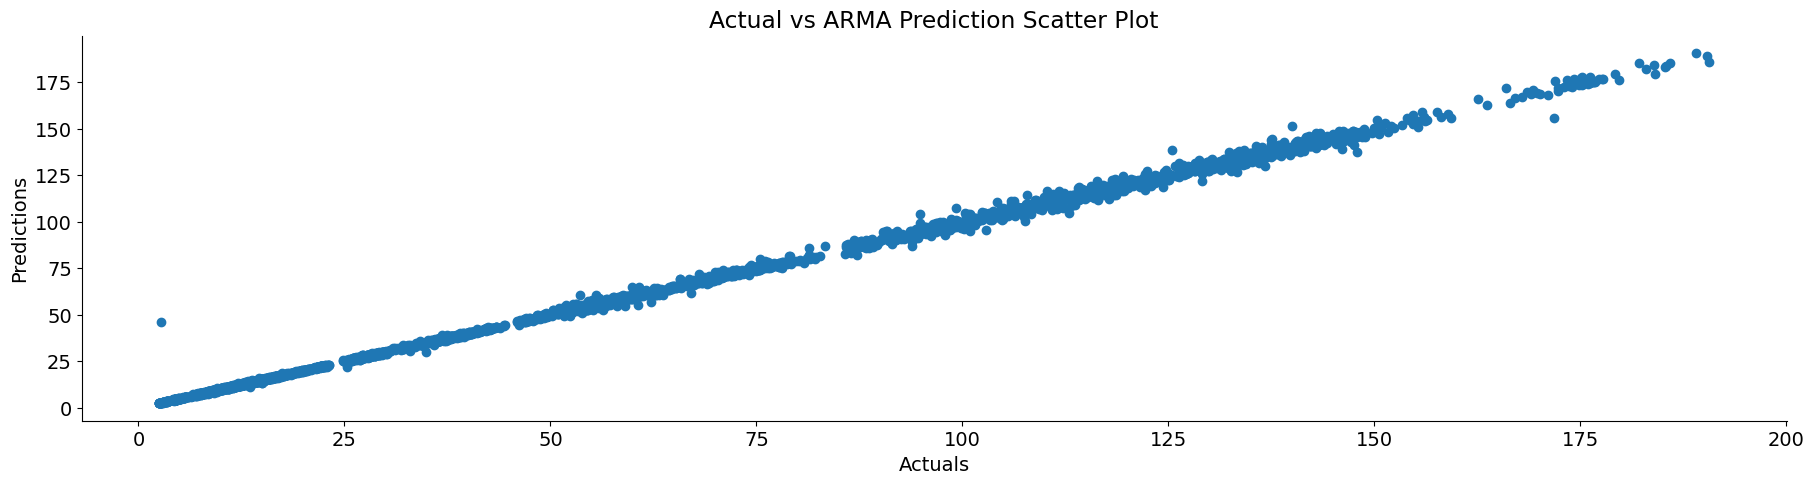

In [43]:
plt.scatter(predictions['Actual'], predictions['predicted_mean'])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Actuals')
plt.ylabel('Predictions')
plt.title('Actual vs ARMA Prediction Scatter Plot')
plt.show()